## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
#自動增長 GPU 記憶體用量的方式，讓程式需要多少記憶體就拿多少
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1]
redice_lr_patient = [5, 2]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0725 20:21:55.619745 14768 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 20:21:55.620745 14768 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 20:21:55.623735 14768 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 20:21:55.678622 14768 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0725 20:21:55.851216 14768 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 20:21:55.866836 14768 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0725 20:21:55.929350 14768 deprecation.py:323] From C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 2s 38us/step - loss: 0.7610 - acc: 0.7583 - val_loss: 1.5133 - val_acc: 0.4981
Epoch 48/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.7592 - acc: 0.7595 - val_loss: 1.5148 - val_acc: 0.4957

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 49/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.7571 - acc: 0.7602 - val_loss: 1.5145 - val_acc: 0.4974
Epoch 50/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.7552 - acc: 0.7614 - val_loss: 1.5142 - val_acc: 0.4972
Numbers of exp: 1, reduce_factor: 0.50, reduce_patient: 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               15

50000/50000 [==============================] - 2s 39us/step - loss: 1.6346 - acc: 0.4315 - val_loss: 1.7428 - val_acc: 0.3917
Epoch 46/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6296 - acc: 0.4321 - val_loss: 1.7392 - val_acc: 0.3926
Epoch 47/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6252 - acc: 0.4340 - val_loss: 1.7361 - val_acc: 0.3931
Epoch 48/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6215 - acc: 0.4350 - val_loss: 1.7327 - val_acc: 0.3964
Epoch 49/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6164 - acc: 0.4375 - val_loss: 1.7299 - val_acc: 0.3949
Epoch 50/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6129 - acc: 0.4384 - val_loss: 1.7262 - val_acc: 0.3972
Numbers of exp: 2, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param

50000/50000 [==============================] - 2s 38us/step - loss: 1.6512 - acc: 0.4251 - val_loss: 1.7547 - val_acc: 0.3967
Epoch 44/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6456 - acc: 0.4266 - val_loss: 1.7515 - val_acc: 0.3968
Epoch 45/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6414 - acc: 0.4265 - val_loss: 1.7478 - val_acc: 0.3958
Epoch 46/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6360 - acc: 0.4295 - val_loss: 1.7441 - val_acc: 0.3983
Epoch 47/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6321 - acc: 0.4298 - val_loss: 1.7414 - val_acc: 0.3993
Epoch 48/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6265 - acc: 0.4326 - val_loss: 1.7388 - val_acc: 0.3991
Epoch 49/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6233 - acc: 0.4324 - val_loss: 1.7347 - val_acc: 0.4012
Epoch 50/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 38us/step - loss: 1.6732 - acc: 0.4176 - val_loss: 1.7698 - val_acc: 0.3833
Epoch 42/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6676 - acc: 0.4185 - val_loss: 1.7655 - val_acc: 0.3847
Epoch 43/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6629 - acc: 0.4193 - val_loss: 1.7613 - val_acc: 0.3856
Epoch 44/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6579 - acc: 0.4206 - val_loss: 1.7581 - val_acc: 0.3867
Epoch 45/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6521 - acc: 0.4234 - val_loss: 1.7539 - val_acc: 0.3857
Epoch 46/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6479 - acc: 0.4254 - val_loss: 1.7504 - val_acc: 0.3894
Epoch 47/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.6431 - acc: 0.4281 - val_loss: 1.7476 - val_acc: 0.3893
Epoch 48/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 40us/step - loss: 0.2545 - acc: 0.9477 - val_loss: 1.7038 - val_acc: 0.5289
Epoch 37/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.2504 - acc: 0.9503 - val_loss: 1.7067 - val_acc: 0.5250
Epoch 38/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.2484 - acc: 0.9510 - val_loss: 1.7172 - val_acc: 0.5248
Epoch 39/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.2456 - acc: 0.9514 - val_loss: 1.7277 - val_acc: 0.5253
Epoch 40/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.2433 - acc: 0.9534 - val_loss: 1.7231 - val_acc: 0.5247

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 41/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.2380 - acc: 0.9559 - val_loss: 1.7256 - val_acc: 0.5249
Epoch 42/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.2365 - acc: 0.9558 -

Epoch 33/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.4547 - acc: 0.4959 - val_loss: 1.6262 - val_acc: 0.4362
Epoch 34/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.4486 - acc: 0.4972 - val_loss: 1.6239 - val_acc: 0.4368
Epoch 35/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4418 - acc: 0.5007 - val_loss: 1.6215 - val_acc: 0.4370
Epoch 36/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4369 - acc: 0.5020 - val_loss: 1.6176 - val_acc: 0.4381
Epoch 37/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4312 - acc: 0.5039 - val_loss: 1.6156 - val_acc: 0.4399
Epoch 38/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4260 - acc: 0.5070 - val_loss: 1.6138 - val_acc: 0.4409
Epoch 39/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4204 - acc: 0.5091 - val_loss: 1.6107 - val_acc: 0.4422
Epoch 40/50
50000/50000 [=========

50000/50000 [==============================] - 2s 39us/step - loss: 1.4592 - acc: 0.4912 - val_loss: 1.6274 - val_acc: 0.4320
Epoch 32/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.4528 - acc: 0.4935 - val_loss: 1.6236 - val_acc: 0.4348
Epoch 33/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4481 - acc: 0.4956 - val_loss: 1.6231 - val_acc: 0.4372
Epoch 34/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4418 - acc: 0.4993 - val_loss: 1.6177 - val_acc: 0.4365
Epoch 35/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4358 - acc: 0.4990 - val_loss: 1.6146 - val_acc: 0.4400
Epoch 36/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4310 - acc: 0.5025 - val_loss: 1.6122 - val_acc: 0.4362
Epoch 37/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.4259 - acc: 0.5039 - val_loss: 1.6115 - val_acc: 0.4402
Epoch 38/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 40us/step - loss: 1.4762 - acc: 0.4884 - val_loss: 1.6454 - val_acc: 0.4310
Epoch 30/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.4694 - acc: 0.4913 - val_loss: 1.6419 - val_acc: 0.4318
Epoch 31/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4638 - acc: 0.4937 - val_loss: 1.6397 - val_acc: 0.4327
Epoch 32/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4568 - acc: 0.4973 - val_loss: 1.6353 - val_acc: 0.4344
Epoch 33/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4511 - acc: 0.4985 - val_loss: 1.6335 - val_acc: 0.4359
Epoch 34/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4455 - acc: 0.4994 - val_loss: 1.6306 - val_acc: 0.4367
Epoch 35/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4400 - acc: 0.5021 - val_loss: 1.6268 - val_acc: 0.4366
Epoch 36/50
50000/50000 [=====================

Epoch 26/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4997 - acc: 0.8457 - val_loss: 1.4924 - val_acc: 0.5311
Epoch 27/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4871 - acc: 0.8519 - val_loss: 1.5073 - val_acc: 0.5256
Epoch 28/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4759 - acc: 0.8564 - val_loss: 1.5469 - val_acc: 0.5257
Epoch 29/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4665 - acc: 0.8599 - val_loss: 1.5281 - val_acc: 0.5304

Epoch 00029: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 30/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4430 - acc: 0.8701 - val_loss: 1.5088 - val_acc: 0.5359
Epoch 31/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4347 - acc: 0.8756 - val_loss: 1.5294 - val_acc: 0.5337
Epoch 32/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4298 - acc

50000/50000 [==============================] - 2s 39us/step - loss: 1.6837 - acc: 0.4135 - val_loss: 1.7840 - val_acc: 0.3861
Epoch 22/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6706 - acc: 0.4182 - val_loss: 1.7742 - val_acc: 0.3899
Epoch 23/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6575 - acc: 0.4221 - val_loss: 1.7673 - val_acc: 0.3885
Epoch 24/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6471 - acc: 0.4249 - val_loss: 1.7592 - val_acc: 0.3934
Epoch 25/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6361 - acc: 0.4296 - val_loss: 1.7503 - val_acc: 0.3949
Epoch 26/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6253 - acc: 0.4335 - val_loss: 1.7425 - val_acc: 0.3974
Epoch 27/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6158 - acc: 0.4367 - val_loss: 1.7353 - val_acc: 0.4009
Epoch 28/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 39us/step - loss: 1.7050 - acc: 0.4092 - val_loss: 1.7849 - val_acc: 0.3818
Epoch 20/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6912 - acc: 0.4133 - val_loss: 1.7749 - val_acc: 0.3848
Epoch 21/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6781 - acc: 0.4160 - val_loss: 1.7642 - val_acc: 0.3866
Epoch 22/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6680 - acc: 0.4215 - val_loss: 1.7562 - val_acc: 0.3909
Epoch 23/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6560 - acc: 0.4254 - val_loss: 1.7457 - val_acc: 0.3938
Epoch 24/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6448 - acc: 0.4294 - val_loss: 1.7388 - val_acc: 0.3999
Epoch 25/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6347 - acc: 0.4327 - val_loss: 1.7309 - val_acc: 0.4004
Epoch 26/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 39us/step - loss: 1.7325 - acc: 0.4014 - val_loss: 1.8085 - val_acc: 0.3756
Epoch 18/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.7165 - acc: 0.4074 - val_loss: 1.7960 - val_acc: 0.3791
Epoch 19/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.7022 - acc: 0.4114 - val_loss: 1.7854 - val_acc: 0.3837
Epoch 20/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6884 - acc: 0.4171 - val_loss: 1.7758 - val_acc: 0.3869
Epoch 21/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6755 - acc: 0.4202 - val_loss: 1.7661 - val_acc: 0.3898
Epoch 22/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6631 - acc: 0.4246 - val_loss: 1.7570 - val_acc: 0.3927
Epoch 23/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6511 - acc: 0.4278 - val_loss: 1.7479 - val_acc: 0.3949
Epoch 24/50
50000/50000 [=====================

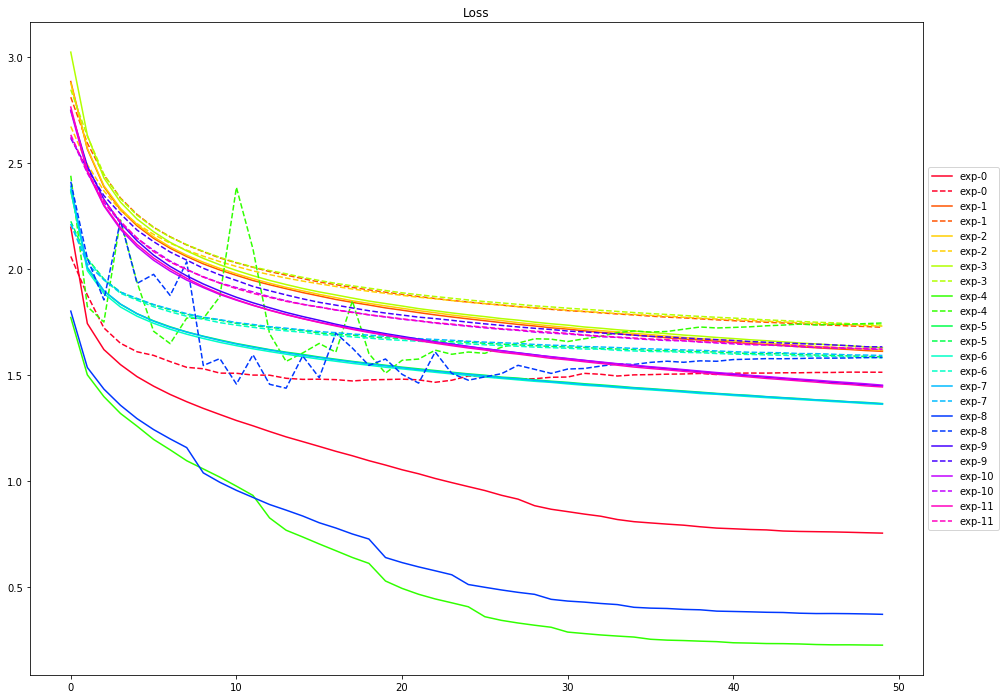

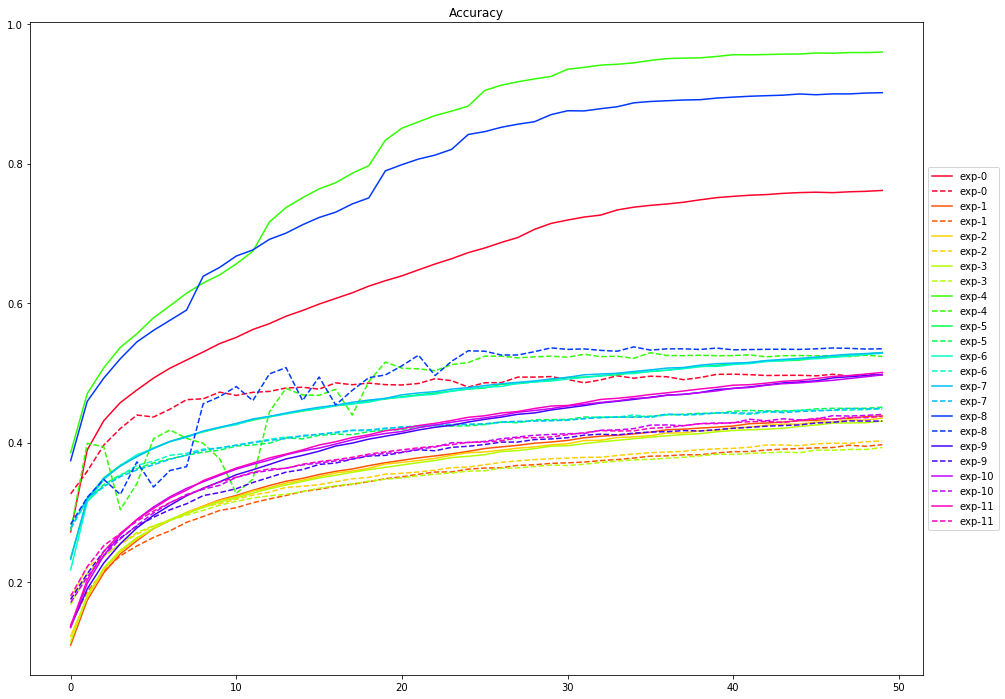

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()